# Characterizing the metastable states of Alanine Dipeptide
### Approach based on the identification of the local minima of the Free Energy Surface.
In this notebook we will use the DeepTICA collective variables of Alanine Dipeptide to characterize its metastable states. We shall look for the local minima of the free energy landscape to identify and label the different metastable states

In [1]:
#Standard imports
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
#MD-related imports
from stateinterpreter import load_trajectory, prepare_training_dataset,Classifier
from stateinterpreter.metastable import identify_metastable_states
from stateinterpreter.utils.io import load_dataframe
from stateinterpreter.utils.plot import plot_classifier_complexity_vs_accuracy,paletteFessa,plot_states
from stateinterpreter.utils.metrics import get_best_reg
from stateinterpreter.descriptors import compute_descriptors

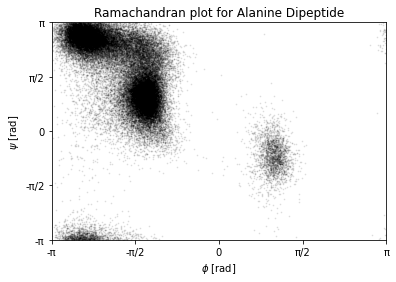

In [2]:
colvar = load_dataframe('alanine/COLVAR_DeepTICA') # Load collective variable file
ax = colvar.plot.scatter('phi','psi',s=0.5, alpha=0.1, c='k')
#Plot Styling
ax.margins(0)
ax.set_xlabel(r"$\phi$ [rad]")
ax.set_ylabel(r"$\psi$ [rad]")
ax.set_title("Ramachandran plot for Alanine Dipeptide")
ax.set_xticks(np.arange(-np.pi, np.pi+np.pi/2, step=(np.pi/2)))
ax.set_xticklabels(['-π','-π/2','0','π/2','π'])
ax.set_yticks(np.arange(-np.pi, np.pi+np.pi/2, step=(np.pi/2)))
ax.set_yticklabels(['-π','-π/2','0','π/2','π'])
plt.show()

### Descriptors
We now show how to use the helper functions implemented in `stateinterpreter` to calculate the physical descriptors starting from a molecular dynamics trajectory. In the present case we compute the H-bonds contacts and the dihedral angles.

In [3]:
traj_dict = {
    'trajectory' : 'alanine/alanine.xtc',
    'topology' : 'alanine/input.ala2.pdb'
}

traj = load_trajectory(traj_dict)
descriptors, feats_info = compute_descriptors( traj[::5], descriptors = ['hbonds_contacts','dihedrals'] )
descriptors.head()

Computing Hydrogen bonds contacts
Donors: [6, 16]
Acceptors: [ 5  6 15 16]
Descriptors: (10001, 10)


,HB_C ACE1-O -- ALA2-N,HB_C ACE1-O -- NME3-N,HB_C ALA2-N -- NME3-N,HB_C ALA2-O -- NME3-N,phi ACE1,sin_phi ACE1,cos_phi ACE1,psi ALA2,sin_psi ALA2,cos_psi ALA2
0,0.929044,0.100502,0.459074,0.930207,-2.368267,-0.698519,-0.715592,2.643943,0.477362,-0.878707
1,0.928530,0.183266,0.440095,0.929337,-1.904493,-0.944838,-0.327538,2.511478,0.589237,-0.807960
2,0.928086,0.522250,0.533442,0.925256,-1.527870,-0.999079,0.042914,1.910308,0.942917,-0.333027
3,0.924332,0.083293,0.408680,0.931586,-2.719540,-0.409634,-0.912250,2.699208,0.428096,-0.903733
4,0.945908,0.143932,0.455699,0.932659,-2.293680,-0.749901,-0.661550,2.575240,0.536558,-0.843863


### Local minima of the free energy surface
We now use the utilities implemented in `stateinterpreter.metastable` to automatically identify the local minima of the free energy surface.

In [4]:
bandwidth = 0.1 # Set the bandwidth for the Gaussian kernel used in the KDE approximation
cvs = colvar[::5] # Select only a subset of configurations
cv_list = ['DeepTICA 1','DeepTICA 2'] # List of collective variables to use for clustering
#Bias correction
kbt = 2.5
logweights = cvs['opes.bias'].values/kbt

states_labels = identify_metastable_states(
    cvs,
    cv_list,
    kbt,
    bandwidth,
    logweights=logweights,
    gradient_descent_iterates = 1,
)

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 3 local minima with selected populations:
	Basin 0 -> 368 configurations.
	Basin 1 -> 3735 configurations.
	Basin 2 -> 4700 configurations.


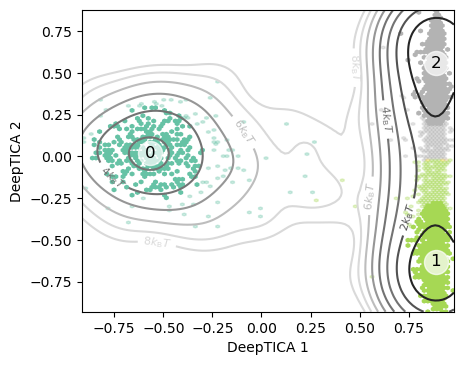

In [5]:
plot_states(
    cvs, 
    states_labels, 
    cv_list, 
    fes_isolines = True, 
    n_iso_fes = 9, 
    ev_iso_labels = 2, 
    alpha=0.3, 
    cmap_name = 'Set2', 
    save_folder=None, 
    axs = None, 
    bandwidth = bandwidth
)

In [6]:
print(f"Example: first 5 labels for the states of the identified metastable states.")
states_labels.head()

Example: first 5 labels for the states of the identified metastable states.


,labels,selection
0,2,True
1,2,True
2,1,False
3,2,True
4,2,True


### Metastable states characterization based on dihedral angles

In [7]:
feat_type = 'angles' #Select feature type
select_feat = 'sin_|cos_' #Regex to filter angle
desc = descriptors.filter(regex=select_feat)
print('Example of the selected descriptors')
desc.head()

Example of the selected descriptors


,sin_phi ACE1,cos_phi ACE1,sin_psi ALA2,cos_psi ALA2
0,-0.698519,-0.715592,0.477362,-0.878707
1,-0.944838,-0.327538,0.589237,-0.807960
2,-0.999079,0.042914,0.942917,-0.333027
3,-0.409634,-0.912250,0.428096,-0.903733
4,-0.749901,-0.661550,0.536558,-0.843863


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:00<00:00, 1293.94it/s]

Best log_10 (lambda) : -1.0
Accuracy        : 100.0 %
No. features    : 4
Accuracy: 100%
State 0:
 sin_phi ACE1
 cos_phi ACE1
State 1:
 sin_phi ACE1
 cos_psi ALA2
 sin_psi ALA2
State 2:
 cos_psi ALA2
 cos_phi ACE1


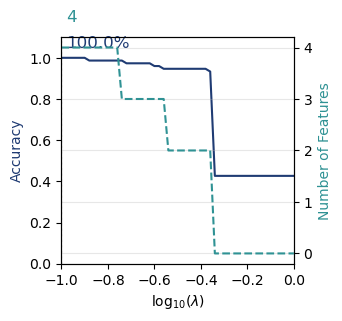

In [11]:
# Init classifier
regularizers = np.geomspace(0.1, 1, 51)
num_samples = 100 # number of configurations used to train the classifier

sample_obj, features_names = prepare_training_dataset(
    descriptors=desc, 
    states_labels = states_labels, 
    n_configs= num_samples
) 
classifier = Classifier(sample_obj, features_names)
classifier.compute(regularizers, max_iter = 10000) # Train the classifier

# Extract optimal regularization parameter
reg,acc,num = get_best_reg(classifier)
print(f'Best log_10 (lambda) : {np.round(np.log10(reg),3)}')
print(f'Accuracy        : {np.round(acc*100,0)} %')
print(f'No. features    : {num}')

# Count states (for plotting purposes)
num_states = len(classifier.classes)
num_histo = num_states if num_states>2 else 1

# Classes names (for plotting purposes)
relevant_feat = classifier.feature_summary(reg)
classes_names = classifier.classes

# Init Plot
fig, ax = plt.subplots(1,1,figsize=(3,3),dpi=100)

# Init Colors 
colors = cycle(iter(paletteFessa[::-1]))
color = [next(colors) for i in range(5)]

# Plot regularization paths.
_, ax_twin = plot_classifier_complexity_vs_accuracy(classifier, ax = ax)
ax.axvline(np.log10(reg),linestyle='dotted',color='k')
ax.text(np.log10(reg)+0.02,acc+.05,f'{np.round(acc*100,1)}%',fontsize=12,color='fessa0')
ax_twin.text(np.log10(reg)+0.02,num+0.5,f'{num}',fontsize=12,color='fessa1')

#Print relevant features
classifier.print_selected(reg)
plt.show()